In [1]:
import numpy as np
import pandas as pd
import pingouin as pg
from scipy import stats

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
from IPython.display import display

from dual_data_utils import make_clean_concat_data
from stopsignalmetrics import StopData, SSRTmodel

# Read in and Compute Metrics on Data

In [2]:
dataset='validation'

In [3]:
OUTLIER_THRESH  = 3
SSD_THRESH = 200

dual_dict = {
    'stop_signal_with_cued_task_switching': {
        'dual_col': 'cue_task_switch',
        'DC': 'cue_stay_task_stay',
        'DE': 'cue_switch_task_switch',
        'OTHER': ['cue_switch_task_stay']
    },
    'stop_signal_with_directed_forgetting': {
        'dual_col': 'directed_forgetting_condition',
        'DC': 'con',
        'DE': 'neg',
        'OTHER': ['pos']
    },
    'stop_signal_with_flanker': {
        'dual_col': 'flanker_condition',
        'DC': 'congruent',
        'DE': 'incongruent'
    },
    'stop_signal_with_go_no_go': {
        'dual_col': 'go_nogo_condition',
        'DC': 'go',
        'DE': 'nogo'
    },
    'stop_signal_with_n_back': {
        'dual_col': 'delay_condition',
        'DC': 1.,
        'DE': 2.,
        'OTHER': [3.]
    },
    'stop_signal_with_predictable_task_switching': {
        'dual_col': 'predictable_condition',
        'DC': 'stay',
        'DE': 'switch'
    },
    'stop_signal_with_shape_matching': {
        'dual_col': 'shape_matching_condition',
        'DC': 'CONTROL',
        'DE': 'DISTRACTOR',
        'OTHER': ['DSD', 'SSS']
    },
}

stopmetrics_var_dict = {
    'columns': {
        'ID': 'worker_id',
        'block': 'current_block',
        'condition': 'SS_trial_type',
        'SSD': 'SS_delay',
        'goRT': 'rt',
        'stopRT': 'rt',
        'response': 'key_press',
        'correct_response': 'choice_correct_response',
        'choice_accuracy': 'choice_accuracy'},
    'key_codes': {
        'go': 'go',
        'stop': 'stop',
        'correct': 1,
        'incorrect': 0,
        'noResponse': -1}}

In [4]:
def get_query_str(col, condition):
    if type(condition)==str:
        return "%s=='%s'" % (col, condition)
    elif type(condition) in [float, int]:
        return "%s==%s" % (col, condition)
    elif type(condition)==list:
        return "%s in %s" % (col, condition)

def stop_summarize(curr_data, thresh=SSD_THRESH, query_str=None):
    data_df = curr_data.query(query_str) if query_str is not None else curr_data
    
    sum_df = SSRTmodel().fit_transform(data_df, level='group')
    sum_df_threshSSDs = SSRTmodel().fit_transform(data_df.query(f'SSD>={thresh} or condition=="go"'), level='group').add_suffix('_wThresh_SSDs')
    sum_df_threshSubs = sum_df.query(f"mean_SSD >= {thresh}").add_suffix('_wThresh_subs')
    return pd.concat([sum_df, sum_df_threshSSDs, sum_df_threshSubs],
                       1,
                       sort=True
                      )

def get_inhib_func(curr_data, cond):
    inhib_df = pd.DataFrame(curr_data.groupby(['ID', 'SSD']).apply(lambda x: x.stopRT.notnull().sum()/len(x))).reset_index()
    inhib_df['condition'] = cond
    return inhib_df

def get_gng_presp(curr_data):
    curr_data = curr_data.copy()
    stop_trials = curr_data.query("stop_signal_condition=='stop'")
    out={}
    out['p_resp'] = (stop_trials.rt != -1).sum()/len(stop_trials)
    out['p_resp_go'] = (stop_trials.query("go_nogo_condition=='go'").rt != -1).sum()/len(stop_trials.query("go_nogo_condition=='go'"))
    out['p_resp_nogo'] = (stop_trials.query("go_nogo_condition=='nogo'").rt != -1).sum()/len(stop_trials.query("go_nogo_condition=='nogo'"))
    return out

In [5]:
stop_data_dict = make_clean_concat_data(stop_subset=True, dataset=dataset)

# Check P(resp|signal) in Go/NoGo 

In [6]:
gng_presp_data = pd.DataFrame(list(stop_data_dict['stop_signal_with_go_no_go'].groupby('worker_id').apply(get_gng_presp)))
gng_presp_data.describe()

,p_resp,p_resp_go,p_resp_nogo
count,33.000000,33.000000,33.000000
mean,0.433333,0.501768,0.022727
std,0.017097,0.016765,0.058751
min,0.371429,0.433333,0.000000
25%,0.428571,0.500000,0.000000
50%,0.435714,0.500000,0.000000
75%,0.442857,0.508333,0.000000
max,0.471429,0.525000,0.300000


In [7]:
del stop_data_dict['stop_signal_with_go_no_go']

# Get SSRT metrics for remaining tasks

In [8]:
# build dict
ssrtc_out = {}
for task_name in stop_data_dict.keys():  # [k for k in stop_data_dict.keys()][:1]:  # development loop using just 1st task
    curr_data = StopData(stopmetrics_var_dict).fit_transform(stop_data_dict[task_name].drop(columns=['correct_response']))
    short_name = task_name.split('_with_')[-1]
    ssrtc_out[short_name] = stop_summarize(curr_data)
    
    if 'with' in task_name:
        dual_col = dual_dict[task_name]['dual_col']
        for key in [k for k in dual_dict[task_name] if k!='dual_col']:
            query_str = get_query_str(dual_col, dual_dict[task_name][key])
            ssrtc_out['%s_%s' % (short_name,key)] = stop_summarize(
                curr_data,
                query_str=query_str
            )

ssrtc_out['SE'] = ssrtc_out.pop('stop_signal_single_task_network')
metrics = [c for c in ssrtc_out['SE'].columns if 'max_RT' not in c]

#flatten data, remove outliers w/ values > 3 SDs from the mean
flattened_data = pd.concat([ssrtc_out[k].add_prefix(k+'_') for k in ssrtc_out], axis=1, sort=True)
flattened_data = flattened_data.filter(regex='SE|DC|DE', axis=1)
z_df = flattened_data.apply(stats.zscore).apply(np.abs)
flattened_data[z_df>OUTLIER_THRESH] = None
flattened_data.index.name='ID'



SSRTs = flattened_data.loc[:, ~flattened_data.columns.str.contains("wThresh")].filter(regex='SSRT')
SSRTs_ThreshSSDs = flattened_data.loc[:, flattened_data.columns.str.contains("wThresh_SSDs")].filter(regex='SSRT')
SSRTs_ThreshSubs = flattened_data.loc[:, flattened_data.columns.str.contains("wThresh_subs")].filter(regex='SSRT')

# Validation Analyses

In [9]:
def filter_out_nans(SSRTs):
    old_nSubs = len(SSRTs)
    SSRTs = SSRTs.dropna()
    new_nSubs = len(SSRTs)
    print(f'{old_nSubs-new_nSubs} subs dropped for nan cell')
    return SSRTs
SSRTs = filter_out_nans(SSRTs)

2 subs dropped for nan cell


# One-way Anova

In [10]:
def mean_SSRTs_within_task(SSRTs):
    SSRTs_taskMeaned = pd.DataFrame()
    for task_name in stop_data_dict.keys():
        short_name = task_name.split('_with_')[-1]
        if short_name == 'stop_signal_single_task_network':
            SSRTs_taskMeaned['SE'] = SSRTs.filter(regex='SE')
        else:
            SSRTs_taskMeaned[short_name] = SSRTs.filter(regex=short_name).mean(1)
    return SSRTs_taskMeaned
SSRTs_taskMeaned = mean_SSRTs_within_task(SSRTs)
SSRTs_taskMeaned.head()

,cued_task_switching,SE,directed_forgetting,flanker,predictable_task_switching,n_back,shape_matching
ID,,,,,,,
s009,168.00,193.916667,296.0,208.25,221.75,248.219758,219.333333
s019,257.00,233.666667,366.0,243.75,261.00,197.663734,294.833333
s031,349.50,237.000000,322.5,292.00,292.75,273.458333,261.583333
s034,233.75,198.500000,390.5,258.00,254.00,320.218750,264.083333
s038,223.75,206.750000,309.5,223.50,194.00,253.545363,223.916667


In [11]:
def melt_taskMeaned_SSRTs(SSRTs_taskMeaned):
    return SSRTs_taskMeaned.reset_index().melt(id_vars='ID')
melted_SSRTs = melt_taskMeaned_SSRTs(SSRTs_taskMeaned)
melted_SSRTs

,ID,variable,value
0,s009,cued_task_switching,168.000000
1,s019,cued_task_switching,257.000000
2,s031,cued_task_switching,349.500000
3,s034,cued_task_switching,233.750000
4,s038,cued_task_switching,223.750000
...,...,...,...
212,s514,shape_matching,296.833333
213,s528,shape_matching,288.666667
214,s541,shape_matching,198.500000
215,s548,shape_matching,305.416667


In [12]:
def run_anova_on_melted_SSRTs(melted_SSRTs):
    return pg.rm_anova(data=melted_SSRTs, dv='value', within='variable', subject='ID', detailed=True)
anova_res = run_anova_on_melted_SSRTs(melted_SSRTs)
anova_res

,Source,SS,DF,MS,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,variable,288913.843232,6,48152.307205,34.753595,1.039136e-27,3.682862e-19,0.536705,0.662985,False,0.178864,0.000482
1,Error,249396.223688,180,1385.534576,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Planned Contrasts

Guidelines from [here](http://web.pdx.edu/~newsomj/uvclass/ho_planned%20contrasts.pdf)

In [13]:
def get_degOfFree(anova_res):
    return anova_res.loc[anova_res.Source=='Error', 'DF'].values[0]

df = get_degOfFree(anova_res)

In [14]:
def get_standardError(anova_res):
    MS = anova_res.loc[anova_res.Source=='Error', 'MS'].values[0]
    return np.sqrt(MS * (2/len(SSRTs)))
std_err = get_standardError(anova_res)

In [15]:
def run_planned_contrasts(SSRTs_taskMeaned, std_err, df):
    planned_tasks = ['directed_forgetting', 'n_back', 'cued_task_switching', 'shape_matching']
    test_res_df = pd.DataFrame(index=planned_tasks, columns=['mean', 't', 'p', 'd'])
    for task in planned_tasks:
        diffs = (SSRTs_taskMeaned.filter(regex=task).values - SSRTs_taskMeaned.filter(regex='SE').values)
        t = np.mean(diffs)/std_err
        pval = stats.t.sf(t, df) 
        print(f'{task}: Mean={np.mean(diffs):.2f}, t={t:.3f}, p={pval:.6f}, d={np.mean(diffs)/np.std(diffs):.2f}')
        test_res_df.loc[task, ['mean', 't', 'p', 'd']] = np.mean(diffs), t, pval, np.mean(diffs)/np.std(diffs)
    return test_res_df

test_res_df = run_planned_contrasts(SSRTs_taskMeaned, std_err, df)

directed_forgetting: Mean=113.67, t=12.023, p=0.000000, d=1.84
n_back: Mean=35.91, t=3.798, p=0.000100, d=0.57
cued_task_switching: Mean=15.36, t=1.624, p=0.053041, d=0.30
shape_matching: Mean=34.85, t=3.686, p=0.000151, d=1.01


## Planned related-samples t-test for n-Back load

In [16]:
def subtract_SE_SSRTs(SSRTs):
    diff_SSRTs = SSRTs.sub(SSRTs.filter(regex='SE').values)
    del diff_SSRTs['SE_SSRT']
    return diff_SSRTs
diff_SSRTs = subtract_SE_SSRTs(SSRTs)

In [17]:
def compare_nBack_load(diff_SSRTs, test_res_df):
    diffs = (diff_SSRTs.n_back_DE_SSRT.values - diff_SSRTs.n_back_DC_SSRT.values)
    t, pval = stats.ttest_rel(diff_SSRTs.n_back_DE_SSRT.values, diff_SSRTs.n_back_DC_SSRT.values, nan_policy='raise', alternative='greater')
    print(f'n-Back DE > DC: Mean={np.mean(diffs):.2f}, t={t:.3f}, p={pval:.6f}, d={np.mean(diffs)/np.std(diffs):.2f}')
    test_res_df.loc['n_back: DE > DC', ['mean', 't', 'p', 'd']] = np.mean(diffs), t, pval, np.mean(diffs)/np.std(diffs)
    return test_res_df

test_res_df = compare_nBack_load(diff_SSRTs, test_res_df)
test_res_df

n-Back DE > DC: Mean=26.16, t=2.277, p=0.015052, d=0.42


,mean,t,p,d
directed_forgetting,113.670699,12.022802,0.0,1.843494
n_back,35.910473,3.798204,0.0001,0.57305
cued_task_switching,15.356183,1.624203,0.053041,0.30466
shape_matching,34.850806,3.686124,0.000151,1.013786
n_back: DE > DC,26.159022,2.276704,0.015052,0.415667


# Visualize

In [18]:
formal_tasks = {
    'All': 'All',
    'SE': 'Single Task',
    'single_task': 'Single Task',
    'go_no_go': 'Go/No-Go',
    'predictable_task_switching': 'Predictable Task Switching',
    'cued_task_switching': 'Cued Task Switching',
    'flanker': 'Flanker',
    'shape_matching': 'Shape Matching',
    'n_back': 'n-Back',
    'directed_forgetting': 'Directed Forgetting' 
}

In [19]:
sns.set(style="whitegrid", palette="colorblind", color_codes=True)
palette ={"DC":"C0", "DE":"C1", "SE":"C2",
         "Dual Low Demand":"C0", "Dual High Demand":"C1", "Single":"C2"}

task_order_dict = {
    'SE': 'aa',
    'go_no_go': 'ab',
    'predictable_task_switching': 'ba',
    'cued_task_switching': 'bb',
    'flanker': 'ca',
    'shape_matching': 'cb',
    'n_back': 'da',
    'directed_forgetting': 'db'
}

trial_order_dict = {
    'Single': 'aa',
    'Dual Low Demand': 'ab',
    'Dual High Demand': 'ba',
}

def context_str(string):
    if 'DC' in string:
        return 'Dual Low Demand'
    elif 'DE' in string:
        return 'Dual High Demand'
    elif 'SE' in string:
        return 'Single'
    elif 'OTHER' in string:
        return 'POS/3BACK/DSD|SSS/CUE_SWITCH'
    else:
        return 'COMBINE'

In [20]:
def clean_SSRTs_for_Barplots(SSRTs):
    melted_SSRTs = SSRTs.reset_index().melt(id_vars='ID', value_name='SSRT')
    melted_SSRTs['Task'] = [i.split('_SSRT')[0].replace('_DC', '').replace('_DE', '') for i in melted_SSRTs['variable']]
    melted_SSRTs['Trial Type'] = [context_str(i) for i in melted_SSRTs['variable']]

    melted_SSRTs['task_order'] = melted_SSRTs['Task'].map(task_order_dict)
    melted_SSRTs['trial_order'] = melted_SSRTs['Trial Type'].map(trial_order_dict)

    melted_SSRTs = melted_SSRTs.sort_values(['task_order', 'trial_order'])
    melted_SSRTs['Task'] = melted_SSRTs['Task'].map(formal_tasks)
    return melted_SSRTs
melted_SSRTs = clean_SSRTs_for_Barplots(SSRTs)
melted_SSRTs

,ID,variable,SSRT,Task,Trial Type,task_order,trial_order
372,s009,SE_SSRT,193.916667,Single Task,Single,aa,aa
373,s019,SE_SSRT,233.666667,Single Task,Single,aa,aa
374,s031,SE_SSRT,237.000000,Single Task,Single,aa,aa
375,s034,SE_SSRT,198.500000,Single Task,Single,aa,aa
376,s038,SE_SSRT,206.750000,Single Task,Single,aa,aa
...,...,...,...,...,...,...,...
119,s514,directed_forgetting_DE_SSRT,258.000000,Directed Forgetting,Dual High Demand,db,ba
120,s528,directed_forgetting_DE_SSRT,356.000000,Directed Forgetting,Dual High Demand,db,ba
121,s541,directed_forgetting_DE_SSRT,369.500000,Directed Forgetting,Dual High Demand,db,ba
122,s548,directed_forgetting_DE_SSRT,429.500000,Directed Forgetting,Dual High Demand,db,ba


In [21]:
title_dataset = dataset if dataset != 'all' else 'combined'

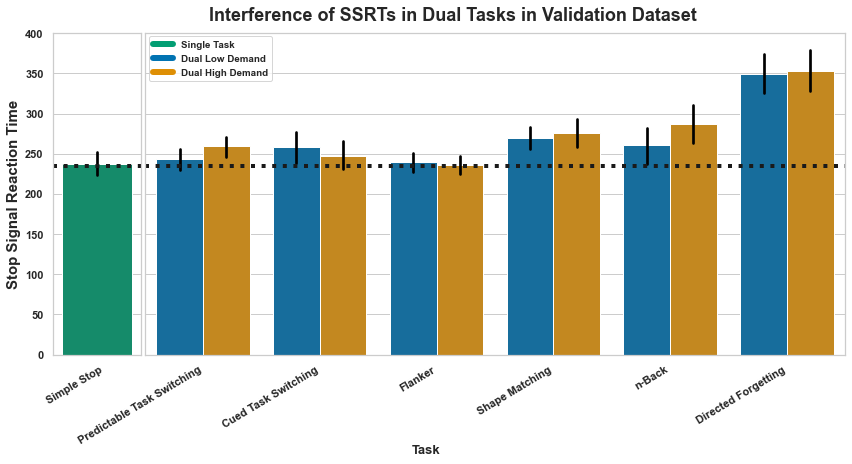

In [22]:
def plot_SSRTs_barplot(melted_SSRTs, save_fig=False):

    f, (a0, a1) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [1, 8]}, sharey=True, figsize=(12,6.5))

    # Single Task
    bar = sns.barplot(x='Task', y='SSRT', hue='Trial Type', data=melted_SSRTs[melted_SSRTs['Trial Type'].isin(['Single'])], palette=palette, errcolor='0', ax=a0)
    a0.axhline(SSRTs['SE_SSRT'].mean()-3, color='k', linestyle=':', linewidth=4)
    a0.set_ylabel('Stop Signal Reaction Time', fontweight='bold', fontsize=15)
    a0.set_xlabel('')
    a0.set_xticks([-.25])
    a0.set_xticklabels(['Simple Stop'], rotation=31, fontweight='bold', fontsize='11')
    a0.set_yticks(np.arange(0, 450, 50))
    a0.set_ylim([0, 400.5])
    a0.set_yticklabels(np.arange(0, 450, 50), fontdict={'fontweight':'bold', 'fontsize':'11'})


    custom_lines = [Line2D([0], [0], color=sns.color_palette()[2], lw=6),
                    Line2D([0], [0], color=sns.color_palette()[0], lw=6),
                    Line2D([0], [0], color=sns.color_palette()[1], lw=6)]
    a0.set_zorder(1)
    a0.legend(custom_lines, ['Single Task', 'Dual Low Demand', 'Dual High Demand'], prop={'weight': 'bold', 'size':9.75}, loc=(1.1,.85), frameon=True)


    # Dual Tasks
    sns.barplot(x='Task', y='SSRT', hue='Trial Type', data=melted_SSRTs[melted_SSRTs['Trial Type'].isin(['Dual Low Demand', 'Dual High Demand'])], palette=palette, errcolor='0', ax=a1)
    a1.axhline(SSRTs['SE_SSRT'].mean()-3, color='k', linestyle=':', linewidth=4)
    a1.set_ylabel('')
    a1.set_xlabel('')
    a1.get_legend().remove()

    # _ = plt.legend(prop={'weight': 'bold'})
    _ = plt.xticks(rotation=31, ha='right', fontweight='bold', fontsize='11')
    _ = plt.yticks(fontweight='bold', fontsize='12')



    _ = f.text(0.5, 0.01, 'Task', ha='center', fontweight='bold', fontsize=13)
    _ = plt.title(f'Interference of SSRTs in Dual Tasks in {title_dataset.capitalize()} Dataset', fontsize='18', fontweight='bold',  y=1.1, x=.44, pad=-20)
    f.tight_layout()
    plt.subplots_adjust(wspace=.01)
    if save_fig:
        plt.savefig(f'figures/dataset-{dataset}_metric-SSRT_barplot.png', dpi=300)
    plt.show()
    plt.close()
    
plot_SSRTs_barplot(melted_SSRTs, save_fig=True)

In [23]:
def clean_diffs_for_Seaborn(diff_SSRTs):
    melted_diffs = diff_SSRTs.reset_index().melt(id_vars='ID', value_name='Dual Task SSRT - Single Task SSRT')
    melted_diffs['Task'] = [i.split('_SSRT')[0].replace('_DC', '').replace('_DE', '') for i in melted_diffs['variable']]
    melted_diffs['Trial Type'] = [context_str(i) for i in melted_diffs['variable']]

    melted_diffs['task_order'] = melted_diffs['Task'].map(task_order_dict)
    melted_diffs['trial_order'] = melted_diffs['Trial Type'].map(trial_order_dict)

    melted_diffs = melted_diffs.sort_values(['task_order', 'trial_order'])
    melted_diffs['Task'] = melted_diffs['Task'].map(formal_tasks)
    return melted_diffs

melted_diffs = clean_diffs_for_Seaborn(diff_SSRTs)
melted_diffs

,ID,variable,Dual Task SSRT - Single Task SSRT,Task,Trial Type,task_order,trial_order
186,s009,predictable_task_switching_DC_SSRT,25.083333,Predictable Task Switching,Dual Low Demand,ba,ab
187,s019,predictable_task_switching_DC_SSRT,39.333333,Predictable Task Switching,Dual Low Demand,ba,ab
188,s031,predictable_task_switching_DC_SSRT,48.500000,Predictable Task Switching,Dual Low Demand,ba,ab
189,s034,predictable_task_switching_DC_SSRT,-2.000000,Predictable Task Switching,Dual Low Demand,ba,ab
190,s038,predictable_task_switching_DC_SSRT,-18.750000,Predictable Task Switching,Dual Low Demand,ba,ab
...,...,...,...,...,...,...,...
119,s514,directed_forgetting_DE_SSRT,5.833333,Directed Forgetting,Dual High Demand,db,ba
120,s528,directed_forgetting_DE_SSRT,88.500000,Directed Forgetting,Dual High Demand,db,ba
121,s541,directed_forgetting_DE_SSRT,181.916667,Directed Forgetting,Dual High Demand,db,ba
122,s548,directed_forgetting_DE_SSRT,194.916667,Directed Forgetting,Dual High Demand,db,ba


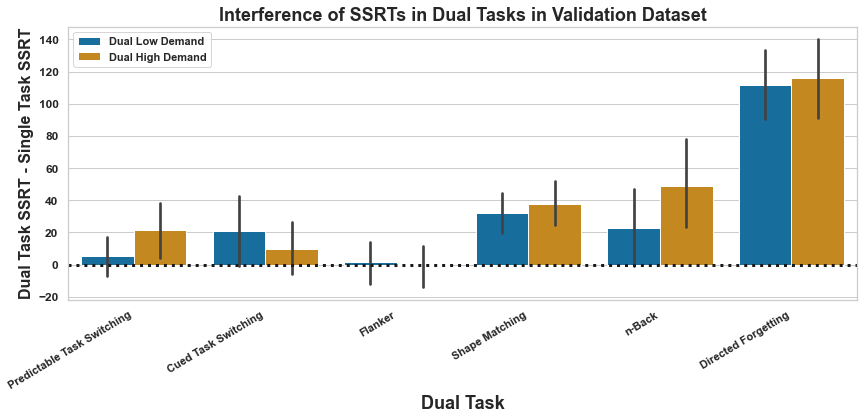

In [24]:
def plot_diffs_barplot(melted_diffs, save_fig=False):

    fig = plt.figure(figsize=(12,6))

    bar = sns.barplot(x='Task', y='Dual Task SSRT - Single Task SSRT', hue='Trial Type', data=melted_diffs, palette=palette)
    plt.legend(prop={'weight': 'bold'})

    _ = plt.xticks(rotation=31, ha='right', fontweight='bold', fontsize='11')
    _ = plt.yticks(fontweight='bold', fontsize='12')

    bar.set_xlabel('Dual Task', fontsize = 18, fontweight='bold')
    bar.set_ylabel('Dual Task SSRT - Single Task SSRT', fontsize = 16, fontweight='bold')

    lowx, highx = plt.xlim()
    plt.plot([lowx, highx],[0,0],color='k',linestyle=':',linewidth=3)
    _ = plt.title(f'Interference of SSRTs in Dual Tasks in {title_dataset.capitalize()} Dataset', fontsize='18', fontweight='bold')
    plt.tight_layout()
    lowy, highy = plt.ylim()
    _ = plt.axis([lowx, highx, lowy, highy])
    if save_fig:
        plt.savefig(f'figures/dataset-{dataset}_metric-SSRT_differences_barplot.png', dpi=300)
    plt.show()
    plt.close()
    
plot_diffs_barplot(melted_diffs, save_fig=True)

# Repetitions with Exclusions

In [25]:
def pipeline(SSRTs, strip_str=''):
    SSRTs = SSRTs.copy()
    SSRTs.columns = [c.replace(strip_str, '') for c in SSRTs.columns]
    SSRTs = filter_out_nans(SSRTs)
    
    # One-way ANOVA
    SSRTs_taskMeaned = mean_SSRTs_within_task(SSRTs)
    melted_SSRTs = melt_taskMeaned_SSRTs(SSRTs_taskMeaned)
    anova_res = run_anova_on_melted_SSRTs(melted_SSRTs)
    display(anova_res)
    
    # Planned Contrasts
    df = get_degOfFree(anova_res)
    std_err = get_standardError(anova_res)
    test_res_df = run_planned_contrasts(SSRTs_taskMeaned, std_err, df)
    
    # n-Back t-test
    diff_SSRTs = subtract_SE_SSRTs(SSRTs)
    test_res_df = compare_nBack_load(diff_SSRTs, test_res_df)

    # Visualizations    
    # All 7 tasks
    melted_SSRTs = clean_SSRTs_for_Barplots(SSRTs)
    plot_SSRTs_barplot(melted_SSRTs, save_fig=False)
    # Diffs Dual SSRTs - Single SSRTs
    melted_diffs = clean_diffs_for_Seaborn(diff_SSRTs)
    plot_diffs_barplot(melted_diffs, save_fig=False)


    return test_res_df

# Exclude Short SSD trials

7 subs dropped for nan cell


,Source,SS,DF,MS,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,variable,40237.252607,6,6706.208768,4.509974,0.000313,0.002045,0.152829,0.676243,False,0.187343,0.008991
1,Error,223045.911874,150,1486.972746,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


directed_forgetting: Mean=37.07, t=3.784, p=0.000111, d=0.62
n_back: Mean=25.51, t=2.605, p=0.005062, d=0.41
cued_task_switching: Mean=15.67, t=1.600, p=0.055858, d=0.28
shape_matching: Mean=34.87, t=3.560, p=0.000249, d=0.91
n-Back DE > DC: Mean=5.14, t=0.255, p=0.400413, d=0.05


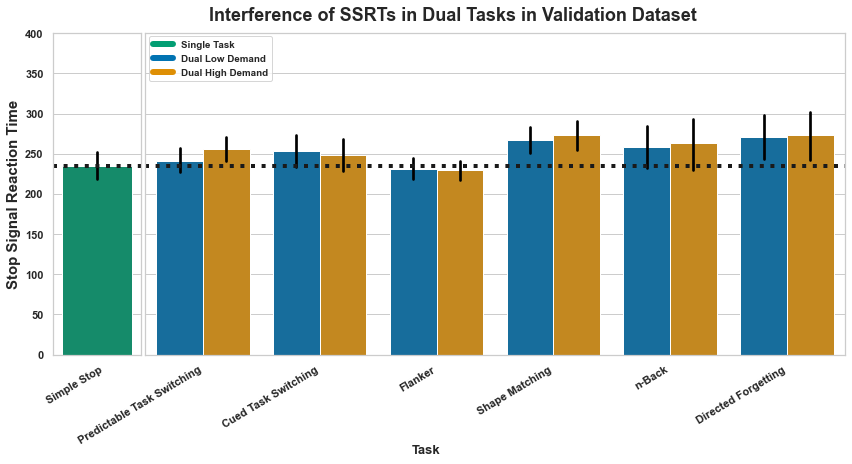

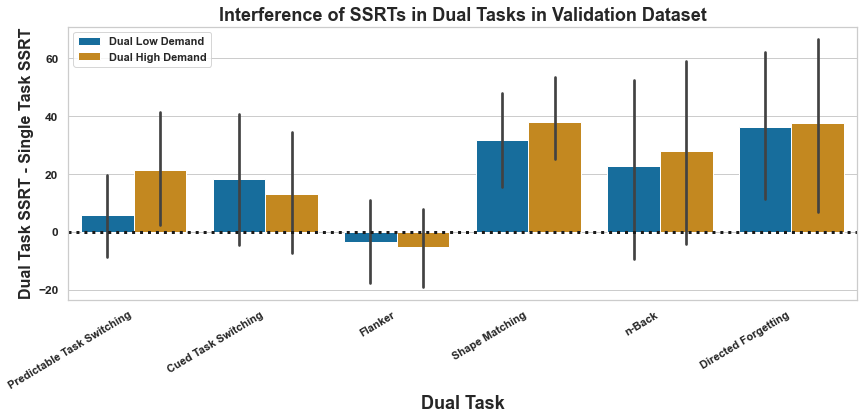

In [26]:
thresh_SSD_tests = pipeline(SSRTs_ThreshSSDs, strip_str='_wThresh_SSDs')

In [27]:
thresh_SSD_tests.to_csv(f'result_csvs/dataset-{dataset}_metric-SSRT_wThresh_SSDs_tests-validationContrasts.csv')

# Exclude Short SSD subjects

22 subs dropped for nan cell


,Source,SS,DF,MS,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,variable,59893.475178,6,9982.245863,9.292882,3.381992e-07,0.000141,0.481674,0.514028,False,0.008501,0.016836
1,Error,64450.915355,60,1074.181923,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


directed_forgetting: Mean=86.23, t=10.358, p=0.000000, d=1.79
n_back: Mean=27.58, t=3.313, p=0.000783, d=0.50
cued_task_switching: Mean=4.45, t=0.535, p=0.297281, d=0.09
shape_matching: Mean=28.94, t=3.476, p=0.000476, d=1.35
n-Back DE > DC: Mean=29.86, t=1.124, p=0.143609, d=0.36


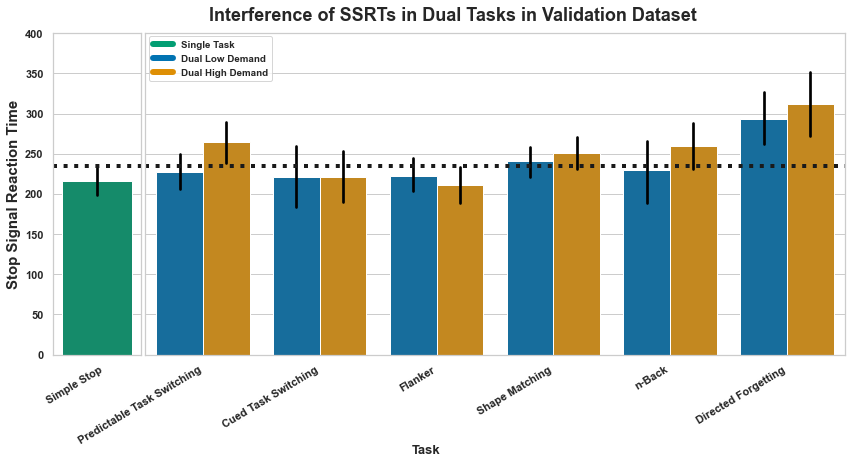

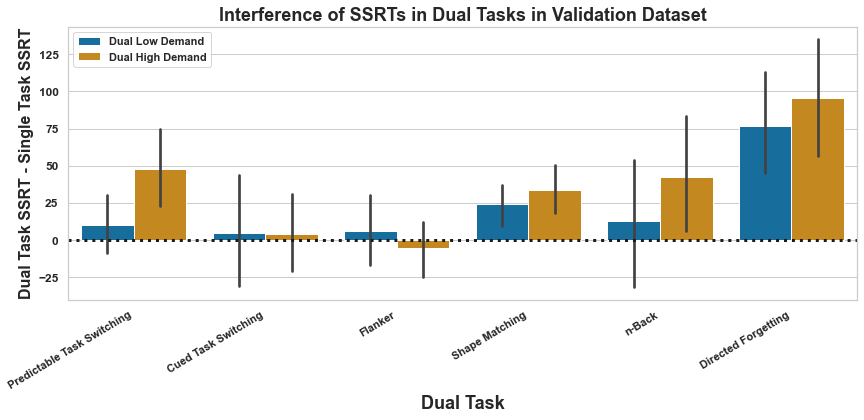

In [28]:
thresh_subs_tests = pipeline(SSRTs_ThreshSubs, strip_str='_wThresh_subs')

In [29]:
thresh_subs_tests.to_csv(f'result_csvs/dataset-{dataset}_metric-SSRT_wThresh_subs_tests-validationContrasts.csv')